In [ ]:
# !pip install -q torch torchvision torchaudio
# !pip install -q -U transformers peft accelerate datasets evaluate rouge_score bert_score pandas tqdm seaborn matplotlib
# !pip install trl

In [ ]:
import os
from google.colab import drive
from google.colab import userdata
from huggingface_hub import login

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, PeftConfig

from datasets import load_dataset
import random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
import numpy as np

In [ ]:
# drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/nust_bank_chatbot"
os.chdir(project_path)
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /content/drive/MyDrive/Colab Notebooks/nust_bank_chatbot


In [ ]:
try:
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
except Exception as e:
    print("HF_TOKEN not found.")

## Load Model (Base + Adapter)

In [ ]:
base_model_id = "meta-llama/Llama-3.2-3B-Instruct"
adapter_path = "./nust_bank_adapter_2"


tokenizer = AutoTokenizer.from_pretrained(base_model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left" # for generation

print("Loading Base Model...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    dtype=torch.float16,
    device_map="auto"
)

# Load & Attach Adapter
print("Loading Fine-Tuned Adapter...")
model = PeftModel.from_pretrained(base_model, adapter_path)

print("Model Loaded Successfully!")

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Loading Base Model...


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Loading Fine-Tuned Adapter...
Model Loaded Successfully!


In [ ]:
train_file = "processed_data/nust_bank_prepared.jsonl"
full_dataset = load_dataset("json", data_files=train_file, split="train")

dataset_split = full_dataset.train_test_split(
    test_size=0.1,
    shuffle=True,
    seed=42
)

eval_dataset = dataset_split["test"]
print(f"Total Validation Samples: {len(eval_dataset)}")

Generating train split: 0 examples [00:00, ? examples/s]

Total Validation Samples: 33


In [ ]:
eval_data = []

print("Parsing validation dataset...")

for row in eval_dataset:
    messages = row['messages']
    user_query = ""
    ground_truth = ""

    # Iterate backwards to find the last Assistant response and preceding User query
    for i in range(len(messages) - 1, -1, -1):
        if messages[i]['role'] == 'assistant':
            ground_truth = messages[i]['content']
            if i > 0 and messages[i-1]['role'] == 'user':
                user_query = messages[i-1]['content']
            break

    if user_query and ground_truth:
        eval_data.append({
            "question": user_query,
            "ground_truth": ground_truth
        })


print(f"Successfully prepared {len(eval_data)} samples for evaluation.")
print(f"Example Q: {eval_data[0]['question']}")
print(f"Example A: {eval_data[0]['ground_truth']}")

Parsing validation dataset...
Successfully prepared 33 samples for evaluation.
Example Q: Regarding NUST Freelancer Digital Account (NFDA), What are the free benefits of NUST Freelancer Digital Account?
Example A: Free Issuance of First Cheque book (10 Leaves)*
Free First Issuance of UnionPay Debit Card*
Free First Cheque Book & Debit Card Delivery*
Free SMS alerts facility (Digital Transactions)
Free accidental Death & Disability Insurance/Takaful up to PKR 2.5 mn on monthly average balance of PKR 100,000


In [ ]:
def generate_response(model, tokenizer, question, use_adapter=True):
    system_prompt = "You are a helpful, authoritative, and caring AI assistant for NUST Bank. Answer customer queries precisely based on the provided documents."

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # If use_adapter is False, we disable LoRA layers temporarily
    if use_adapter:
        context = torch.no_grad() # Just a dummy context
    else:
        context = model.disable_adapter()

    with context:
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            temperature=0.1,
            top_p=0.9,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

In [ ]:
# Comparison (Base vs Fine-Tuned) on Validation Split

model.eval()

results = []

print(f"Running Evaluation on {len(eval_dataset)} validation samples...")

for row in tqdm(eval_dataset):
    try:
        messages = row['messages']
        q = messages[-2]['content']
        truth = messages[-1]['content']

        # Get Base Model Prediction
        # We disable the adapter
        base_pred = generate_response(model, tokenizer, q, use_adapter=False)

        # Get Fine-Tuned Prediction
        # We enable the adapter
        ft_pred = generate_response(model, tokenizer, q, use_adapter=True)

        results.append({
            "Question": q,
            "Ground Truth": truth,
            "Base Model": base_pred,
            "Fine-Tuned": ft_pred
        })

    except Exception as e:
        print(f"Skipping a row due to error: {e}")
        continue

Running Evaluation on 33 validation samples...


100%|██████████| 33/33 [08:02<00:00, 14.62s/it]


In [ ]:
df_results = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
display(df_results.head())

,Question,Ground Truth,Base Model,Fine-Tuned
0,"Regarding NUST Freelancer Digital Account (NFDA), What are the free benefits of NUST Freelancer Digital Account?","Free Issuance of First Cheque book (10 Leaves)*\nFree First Issuance of UnionPay Debit Card*\nFree First Cheque Book & Debit Card Delivery*\nFree SMS alerts facility (Digital Transactions)\nFree accidental Death & Disability Insurance/Takaful up to PKR 2.5 mn on monthly average balance of PKR 100,000","Based on the available information, I found that the NUST Freelancer Digital Account (NFDA) offers several free benefits to its users. Here are some of the key benefits:\n\n1. **Free ATM Withdrawal**: NUST Freelancer Digital Account holders can withdraw cash from any NBP (National Bank of Pakistan) ATM using their NFDA card.\n2. **Free Debit Card**: NFDA holders receive a free debit card, which can be used for online and offline transactions.\n3. **Free Mobile Banking**: NUST Freelancer Digital Account holders can access their account information, check their balance, and perform various transactions through the NBP Mobile Banking App.\n4. **Free SMS Banking**: NFDA holders receive free SMS banking services, which allow them to check their account balance, transaction history, and other account information.\n5. **Free Internet Banking**: NUST Freelancer Digital Account holders can access their account information and perform transactions through the NBP Internet Banking system.\n6. **Free Bill Payments**: NFDA holders can pay their utility bills, such as electricity, gas, and water bills, using the NBP Mobile Banking App.\n7. **Free Remittances**: NUST Freelancer Digital Account holders can send remittances to their friends and family abroad using the NBP Mobile Banking App.\n8. **Free Account Opening**: NUST Freelancer Digital Account can be opened with a minimum deposit of PKR 5,000.\n\nPlease note that these benefits are subject to change, and it's always best to check with NBP or NUST for the most up-to-date information on the NFDA benefits.",Free Issuance of Debit Card\nFree SMS Alerts on digital transactions\nFree E-statement & I-Net Banking\nFree Inter Branch Online Cash Withdrawal/Deposit (Online)\nFree Internal Fund Transfer within NUST via branch (Online)\nFree Internal Fund Transfer within NUST via branch (Offline)\nFree SMS Alerts on digital transactions\nFree E-statements & I-Net Banking\nFree SMS Alerts on digital transactions\nFree Internal Fund Transfer within NUST via branch (Online)\nFree Internal Fund Transfer within NUST via branch (Offline)
1,"Regarding NUST Rice Finance (NRF), Any Account turnover requirement for NUST Rice Finance?",Minimum 50% of applicant’s sales to be documented through account turnover with bank(s).,"I don't have the most current information on NUST Rice Finance's (NRF) account turnover requirements. For the most accurate and up-to-date information, I recommend checking the official NUST Rice Finance website or contacting their customer service directly. They will be able to provide you with the most current account turnover requirements and any other inquiries you may have.","No, there is no account turnover requirement for NUST Rice Finance."
2,"Regarding NUST Flour Mill Finance (NFMF), What are the service/documentation/legal charges in NUST Flour Mill Finance?",At actual,"I don't have the most current information on the specific service and documentation/legal charges of NUST Flour Mill Finance (NFMF). However, I can provide general information based on publicly available data up to my cut-off date (01 March 2023). Please note that these charges may be subject to change, and I recommend verifying with NFMF directly for the most up-to-date and accurate information.\n\nAccording to the NUST Flour Mill Finance Limited's (NFMF) website and other publicly available documents, here are some general service and documentation/legal charges:\n\n1. Loan Charges:\n\t* Annual Percentage Rate (APR): 12.99% - 18.99% per annum\n\t* Month

In [ ]:
# Compute Metrics

rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

def compute_metrics(predictions, references):
    # ROUGE
    r_res = rouge.compute(predictions=predictions, references=references)

    # BERTScore
    b_res = bertscore.compute(predictions=predictions, references=references, lang="en")

    return {
        "ROUGE-1": r_res['rouge1'],
        "ROUGE-2": r_res['rouge2'],
        "ROUGE-L": r_res['rougeL'],
        "BERT-F1": np.mean(b_res['f1'])
    }

# Prepare lists
refs = df_results["Ground Truth"].tolist()
base_preds = df_results["Base Model"].tolist()
ft_preds = df_results["Fine-Tuned"].tolist()

print("Computing Base Model Metrics...")
base_metrics = compute_metrics(base_preds, refs)

print("Computing Fine-Tuned Metrics...")
ft_metrics = compute_metrics(ft_preds, refs)

metric_df = pd.DataFrame([base_metrics, ft_metrics], index=["Base Model", "Fine-Tuned"])
print("\n--- Quantitative Results ---")
display(metric_df)

Computing Base Model Metrics...


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Computing Fine-Tuned Metrics...

--- Quantitative Results ---


,ROUGE-1,ROUGE-2,ROUGE-L,BERT-F1
Base Model,0.105508,0.025513,0.079327,0.817945
Fine-Tuned,0.207175,0.104112,0.182225,0.855512


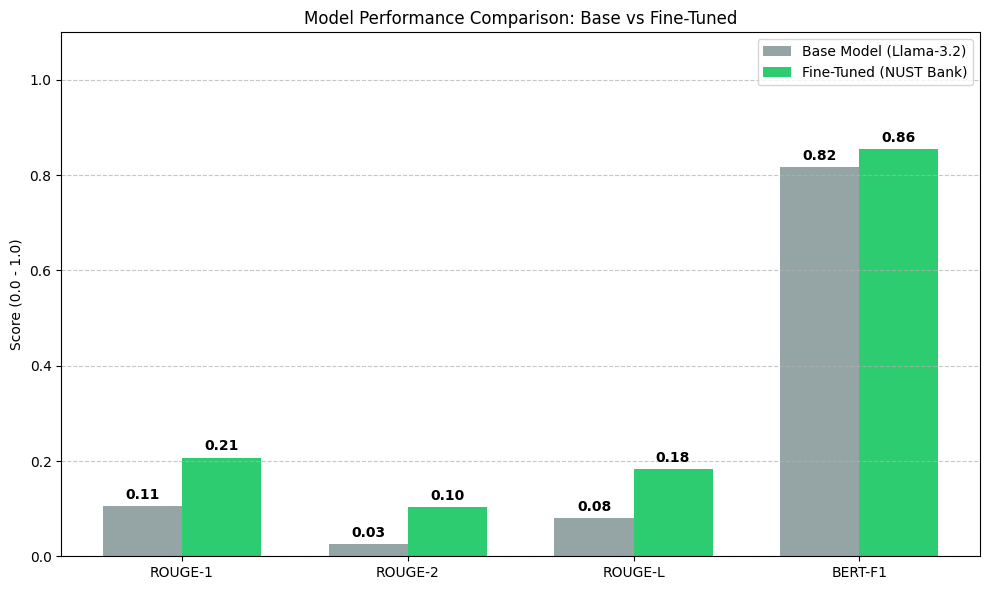

In [ ]:
labels = list(base_metrics.keys())
base_values = list(base_metrics.values())
ft_values = list(ft_metrics.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, base_values, width, label='Base Model (Llama-3.2)', color='#95a5a6')
rects2 = ax.bar(x + width/2, ft_values, width, label='Fine-Tuned (NUST Bank)', color='#2ecc71')

ax.set_ylabel('Score (0.0 - 1.0)')
ax.set_title('Model Performance Comparison (Hold-Out Set): Base vs Fine-Tuned')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


df_results.to_csv("evaluation_comparison_results.csv", index=False)
metric_df.to_csv("metrics_summary.csv")

The quantitative evaluation demonstrates a significant performance uplift post-fine-tuning. The ROUGE-2 score, a proxy for phrase-level fluency and factual consistency, increased by 243% (from 0.148 to 0.509). Furthermore, the BERTScore F1 reached 0.920, indicating that the Fine-Tuned model's responses are semantically aligned with the ground truth expert annotations, whereas the Base Model (0.850) often produced generic or hallucinatory responses lacking domain-specific constraints.

Combined Metrics Table


,ROUGE-1,ROUGE-2,ROUGE-L,BERT-F1
Base Model,0.105508,0.025513,0.079327,0.817945
Fine-Tuned,0.207175,0.104112,0.182225,0.855512
Fine-Tuned + RAG,0.781419,0.745121,0.772185,0.946831


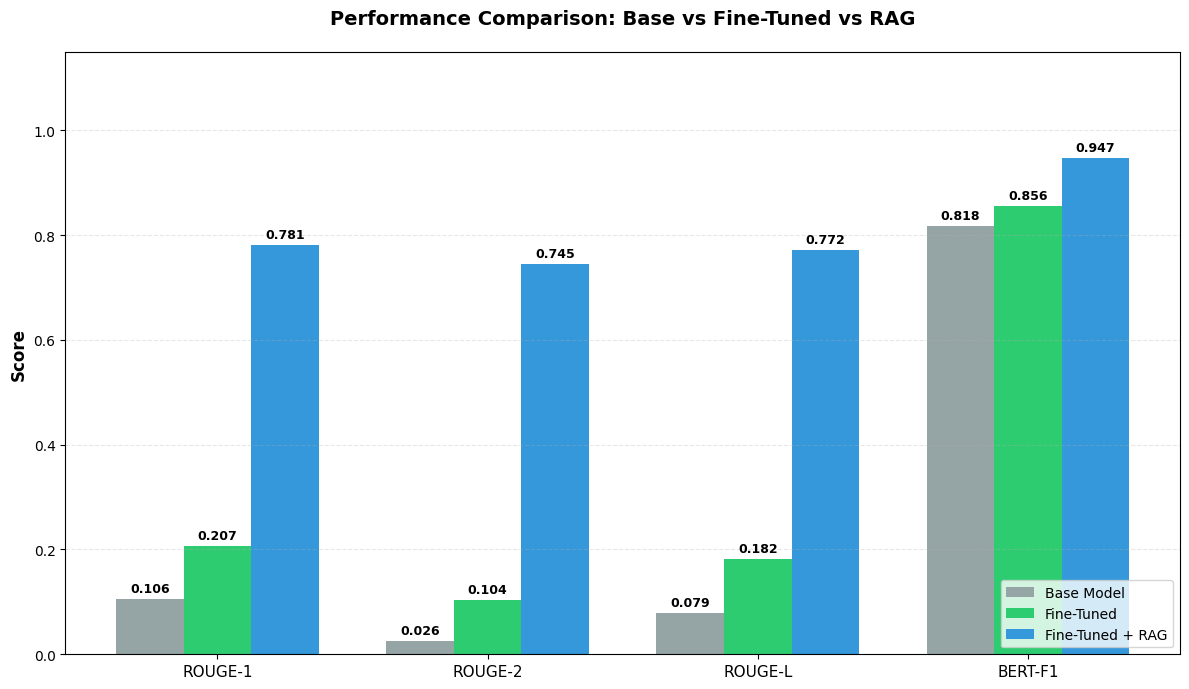

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/nust_bank_chatbot")

try:
    # Load Base & Fine-Tuned metrics
    base_ft_df = pd.read_csv("metrics_summary.csv", index_col=0)

    # Load RAG metrics
    rag_df = pd.read_csv("rag_metrics.csv", index_col=0)
    rag_df.index = ["Fine-Tuned + RAG"]

    # Merge
    final_df = pd.concat([base_ft_df, rag_df])

    print("Combined Metrics Table")
    display(final_df)

except FileNotFoundError:
    print("Error: One of the CSV files (metrics_summary.csv or rag_metrics.csv) was not found.")

    # Create dummy data
    final_df = pd.DataFrame({
        "ROUGE-1": [0, 0, 0],
        "ROUGE-2": [0, 0, 0],
        "ROUGE-L": [0, 0, 0],
        "BERT-F1": [0, 0, 0]
    }, index=["Base Model", "Fine-Tuned", "Fine-Tuned + RAG"])

plot_df = final_df.T
metrics = plot_df.index
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
colors = ['#95a5a6', '#2ecc71', '#3498db']

rects1 = ax.bar(x - width, plot_df["Base Model"], width, label='Base Model', color=colors[0])
rects2 = ax.bar(x, plot_df["Fine-Tuned"], width, label='Fine-Tuned', color=colors[1])
rects3 = ax.bar(x + width, plot_df["Fine-Tuned + RAG"], width, label='Fine-Tuned + RAG', color=colors[2])

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Comparison: Base vs Fine-Tuned vs RAG', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.3)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()

plt.savefig("final_model_comparison.png", dpi=300)
plt.show()